<span style="font-size: 20pt;"><span style="font-weight: bold;">Chapter 11.</span>Introducing natural language processing: Cleaning, summarising, and classifying text</span>

Last update: 12 January 2024

Thank you for checking out the code for: 

> Hogan, Bernie (2023) _From Social Science to Data Science_. London, UK: Sage Publications. 

This notebook contains the code from the book, along with the headers and additional author notes that are not in the book as a way to help navigate the code. You can run this notebook in a browser by clicking the buttons below. 
    
The version that is uploaded to GitHub should have all the results pasted, but the best way to follow along is to clear all outputs and then start afresh. To do this in Jupyter go the menu and select "Kernel -> Restart Kernel and Clear all Outputs...". To do this on Google Colab go to the menu and select "Edit -> Clear all outputs".
    
The most up-to-date version of this code can be found at https://www.github.com/berniehogan/fsstds 

Additional resources and teaching materials can be found on Sage's website for this book. 

All code for the book and derivative code on the book's repository is released open source under the  MIT license. 
    

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/berniehogan/fsstds/main?filepath=chapters%2FCh.11.NLP.ipynb)[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berniehogan/fsstds/blob/main/chapters/Ch.11.NLP.ipynb)

<span style="font-size: 20pt;">📺 YouTube Video lecture for this chapter 📺</span>

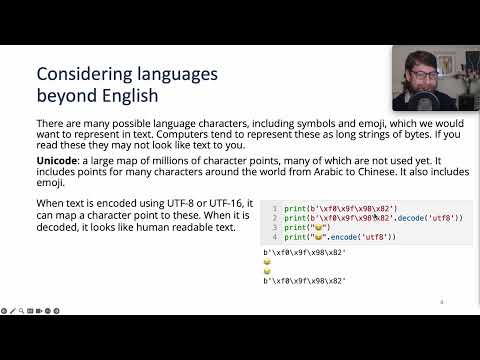

In [41]:
from IPython.display import YouTubeVideo

YouTubeVideo('enMGB_dFEFE')

# Reading language: Encoding text

## Key definitions in text

In [1]:
hex(27)

'0x1b'

In [2]:
print("a",ord("a"))

a 97


In [3]:
# 0 through 32 do not show up below or are whitespace, so they are omitted
for i in range(33,127): print(chr(i),end="")

!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~

# From Text to Language

In [4]:
# import pickle
from pathlib import Path
import pandas as pd 

stack = "movies"
data_dir = Path().cwd().parent / "data" 

stack_df = pd.read_feather(data_dir / "movies_stack_df.feather")

# Old code: (using pickles)
#
# pickle_file = data_dir / "movies.stackexchange.com" / "movies.pkl"

# if pickle_file.exists():
#     stack_df = pickle.load(open(pickle_file ,'rb'))
#     print(stack_df.shape)
# else:
#     print("Please download and clean the Stack_df data as done in Chapter 10",
#           "The data is available from",
#           "https://archive.org/download/stackexchange")

# A sample simple NLP workflow 

## Preprocessing text 

### Word tokenisation

In [5]:
import pandas as pd 

In [6]:
s = "It was the best of times, it was the worst of times."

pd.Series(s.split(" ")).value_counts()

was       2
the       2
of        2
It        1
best      1
times,    1
it        1
worst     1
times.    1
Name: count, dtype: int64

In [7]:
from nltk.tokenize import wordpunct_tokenize

In [8]:
result = wordpunct_tokenize(s)
pd.Series(result).value_counts()

was      2
the      2
of       2
times    2
It       1
best     1
,        1
it       1
worst    1
.        1
Name: count, dtype: int64

### Stop words

In [9]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/berniehogan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
stopWords = set(stopwords.words('english'))

result_filtered = [word for word in result
                   if (word.lower() not in stopWords) and word.isalpha()]

pd.Series(result_filtered).value_counts()

times    2
best     1
worst    1
Name: count, dtype: int64

### Stemming and lemmatisation

In [11]:
from nltk import PorterStemmer 

In [12]:
text = '''After running for office, his campaign office ran a huge tab 
for the victory party. But with finances officially in trouble, his 
 finance officer ran away stating "it was a good run"!'''

tokens = wordpunct_tokenize(text)

tokens_filtered = [word.lower() for word in tokens
                   if (word.lower() not in stopWords) and word.isalpha()]

porter = PorterStemmer()
stemlist = [porter.stem(t) for t in tokens_filtered]

pd.Series(stemlist).value_counts()

offic       3
run         2
ran         2
financ      2
campaign    1
huge        1
tab         1
victori     1
parti       1
offici      1
troubl      1
away        1
state       1
good        1
Name: count, dtype: int64

In [13]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

wlemma = WordNetLemmatizer()

lemmadf = pd.DataFrame(tokens_filtered,columns=["Word"])
lemmadf['Lemma'] = lemmadf["Word"].map(
                       lambda word: wlemma.lemmatize(word, pos="v"))
lemmadf[:12].style.hide(axis="index")

Word,Lemma
running,run
office,office
campaign,campaign
office,office
ran,run
huge,huge
tab,tab
victory,victory
party,party
finances,finance


# NLP Approaches to analysis

## Scoring documents with sentiment analysis 

In [14]:
try: 
    import vaderSentiment
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install vaderSentiment
    import vaderSentiment

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

texts = ["Wow I'm feeling great today, the weather is lovely. HOORAY!!!",
         "I would be lying if I said this was a really bad day",
         "I would not be lying if I said this was a really bad day",
         "Hey bro! Those sick beats brought down the house!"]

for i in texts:
    print(i, analyzer.polarity_scores(i), sep="\n", end="\n\n")

Wow I'm feeling great today, the weather is lovely. HOORAY!!!
{'neg': 0.0, 'neu': 0.216, 'pos': 0.784, 'compound': 0.959}

I would be lying if I said this was a really bad day
{'neg': 0.395, 'neu': 0.605, 'pos': 0.0, 'compound': -0.8016}

I would not be lying if I said this was a really bad day
{'neg': 0.204, 'neu': 0.646, 'pos': 0.149, 'compound': -0.254}

Hey bro! Those sick beats brought down the house!
{'neg': 0.327, 'neu': 0.673, 'pos': 0.0, 'compound': -0.5972}



In [16]:
%%time

sample_df = stack_df.sample(2000,random_state=12345).copy()

senti_sr = sample_df["BodyText"].map(
    lambda text: analyzer.polarity_scores(text))

senti_df = pd.json_normalize(senti_sr)
senti_df.index = senti_sr.index

sample_df = pd.concat([sample_df, senti_df],axis=1)

pd.set_option('display.max_colwidth',200)

display(sample_df[["BodyText","pos","neg"]].head())


,BodyText,pos,neg
7791,"This is all just speculation, but some points to consider: How many bottles of this “petrol” would be required to get to 88 mph? To what degree is this “petrol” compatible with combustion engines...",0.000,0.051
5443,"Initially it was a intended to be a drama, but as Kubrick started to work on the screenplay he began to see the absurdity and humor in many of the scenes and decided to write instead a ""nightmare...",0.110,0.123
31224,"I am currently doing an analysis on the movie ""The Machinist"", which also includes an environmental analysis. I'm trying to figure out why Trevor is working as an industrial machinist at a factory...",0.000,0.000
38188,John tried to face the detectives and tried to take photos of them in Se7en movie. What is the reason?,0.000,0.000
55442,"Does Revolutions XX00 mean the RPM of the propeller shaft? Yes, it does Why do the crew talk about propeller shaft RPM? What are they communicating? Because they know from experience what revo...",0.036,0.024


CPU times: user 936 ms, sys: 10.1 ms, total: 946 ms
Wall time: 958 ms


## Extracting keywords: TF-IDF Scores

In [17]:
# As a convenience, all the imports needed for this function
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer 

In [18]:
def clean_text(text, lower_case = True, stop_words = True, 
               lemma = True, join_words = " "):

    if lower_case: text = text.lower()

    tokens = [x for x in wordpunct_tokenize(text) if x.isalpha()]

    if stop_words: 
        tokens = [word for word in tokens 
                  if word not in stopwords.words('english')]
    if lemma: 
        tokens = [WordNetLemmatizer().lemmatize(word,pos='v') 
                  for word in tokens]

    if join_words:    return join_words.join(tokens)
    else:             return tokens


In [19]:
%%time 
# Multiprocessing doesn't really help here unfortunately

documents = sample_df["BodyText"].map(clean_text)

CPU times: user 6.94 s, sys: 1.99 s, total: 8.94 s
Wall time: 9.03 s


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer()

wordmat = vectorizer.fit_transform(documents).todense()

In [21]:
# From the video - some things to check 

# print(dir(vectorizer))

print(wordmat)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [22]:
tfidf_scores = wordmat.sum(axis=0)

print(tfidf_scores)

print(tfidf_scores.A1)


[[0.18169896 0.10037503 1.94813427 ... 0.14068523 0.22302795 0.23354509]]
[0.18169896 0.10037503 1.94813427 ... 0.14068523 0.22302795 0.23354509]


In [23]:
word_list = vectorizer.get_feature_names_out()

top_words = pd.Series(tfidf_scores.A1, index=word_list)

display(top_words.sort_values(ascending=False)[:10])

movie    39.532631
film     39.447474
would    33.622581
one      33.169395
time     30.221115
show     30.110691
know     30.110662
see      29.650258
make     29.310130
say      27.825130
dtype: float64

## Text Classication 

### Naive Bayes Classifier as an example 

In [24]:
from nltk import NaiveBayesClassifier,classify

In [25]:
%%time 

nbc_df = stack_df[(stack_df["PostTypeId"]=='1') |
                  (stack_df["PostTypeId"]=='2')] \
                 [["PostTypeId","BodyText"]][:2000]

nbc_df["CleanTokens"] = nbc_df["BodyText"].map(
                         lambda x: clean_text(x,join_words=False))

CPU times: user 6.19 s, sys: 1.8 s, total: 8 s
Wall time: 8.1 s


In [26]:
from collections import Counter 

In [30]:
# Counter(nbc_df["CleanTokens"].sum())

In [31]:
min_count = 50
all_words =  pd.Series(Counter(nbc_df["CleanTokens"].sum()))
# all_words[all_words >= min_count]

print(len(all_words[all_words >= min_count]))

452


In [37]:
min_count = 10

all_words =  pd.Series(Counter(nbc_df["CleanTokens"].sum()))
# Alternative approach using value_counts instead of Counter
# all_words =  pd.Series(nbc_df["CleanTokens"].sum()).value_counts()


print(f"{len(all_words)} words in total.",
      f"{len(all_words[all_words >= min_count])} appear at least",
      f"{min_count} times.")

above_min_words = frozenset(all_words[all_words >= min_count].index)

12748 words in total. 2130 appear at least 10 times.


In [38]:
features = nbc_df["CleanTokens"].map(lambda x: 
                {i:i in set(x) for i in above_min_words})

print(nbc_df["PostTypeId"].value_counts())

feature_list = list(zip(features, nbc_df["PostTypeId"]))

PostTypeId
2    1192
1     808
Name: count, dtype: int64


In [39]:
%%time

train_set, test_set = feature_list[:1000], feature_list[1000:]
classifier = NaiveBayesClassifier.train(train_set)

print(f"The accuracy of the classifier is {classify.accuracy(classifier, test_set):0.3f}")

print(classifier.show_most_informative_features(5));

The accuracy of the classifier is 0.675
Most Informative Features
                    wiki = True                2 : 1      =      8.1 : 1.0
                 anybody = True                1 : 2      =      7.2 : 1.0
               excellent = True                2 : 1      =      6.3 : 1.0
                    tone = True                2 : 1      =      6.3 : 1.0
                 disease = True                1 : 2      =      6.2 : 1.0
None
CPU times: user 1.74 s, sys: 8.63 ms, total: 1.75 s
Wall time: 1.77 s


# Summary

# Further reading 

# Extensions and reflections 